In [76]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.prepared import prep
import matplotlib.pyplot as plt
import os
import rioxarray as rxr

In [77]:
dsug = pd.read_csv('data/db_sugar_maple.csv', dtype={'latitude': 'float64', 'longitude': 'float64'})


In [78]:
dsug

,Unnamed: 0,essence,latitude,forest,longitude,elev,ph,clay,sand,bio1,...,bio15,bio18,bio20,bio23,bio24,bio27,bio30,bio31,bio34,cluster_k
0,1,ES,47.996187,94,-68.500146,364,4.2000,11.0,56.0,2.377832,...,13.184971,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280,2
1,2,ES,47.849696,100,-68.513409,392,4.2000,11.0,56.0,2.377832,...,13.184971,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280,2
2,25,ES,48.006817,100,-69.845383,263,4.3200,4.0,85.0,1.877924,...,10.672174,275.200,16.294031,90.193054,615.300,31.653698,-2.362497,5.388228,645.53110,2
3,46,ES,47.464966,100,-69.830670,187,3.5167,24.0,45.0,2.599420,...,12.382082,285.675,17.312328,82.792880,613.000,31.961720,-1.030399,6.622469,701.65955,2
4,52,ES,47.692467,100,-68.633707,334,3.8233,16.0,43.0,2.377832,...,13.184971,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565303,1658294,ES,48.267805,98,-68.241756,388,4.2000,11.0,56.0,1.643488,...,12.637121,267.200,15.901118,91.217125,606.500,31.554630,0.717934,4.496501,666.30770,2
565304,1658300,ES,48.226767,91,-68.151074,442,3.8233,16.0,43.0,1.643488,...,12.637121,267.200,15.901118,91.217125,606.500,31.554630,0.717934,4.496501,666.30770,2
565305,1658302,ES,48.226779,96,-68.148912,414,3.8233,16.0,43.0,1.643488,...,12.637121,267.200,15.901118,91.217125,606.500,31.554630,0.717934,4.496501,666.30770,2
565306,1658309,ES,48.619350,37,-67.341882,197,4.2000,11.0,56.0,1.677881,...,17.265238,296.875,15.893673,96.534830,630.800,31.110240,-2.917435,6.463537,658.10010,2


In [79]:
geometry = [Point(lon, lat) for lon, lat in zip(dsug['longitude'], dsug['latitude'])]
presences_gdf = gpd.GeoDataFrame(dsug.copy(), geometry=geometry, crs="EPSG:4326")

In [80]:
# 4. Reproyectar
from pyproj import Transformer
from shapely.ops import transform

In [81]:
print("Reproyectando presencias...")
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32198", always_xy=True)
presences_proj_geom = presences_gdf.geometry.apply(lambda geom: transform(transformer.transform, geom))
presences_proj = gpd.GeoDataFrame(presences_gdf.drop(columns='geometry'), geometry=presences_proj_geom)
presences_proj.set_crs("EPSG:32198", allow_override=True, inplace=True)

Reproyectando presencias...


,Unnamed: 0,essence,latitude,forest,longitude,elev,ph,clay,sand,bio1,...,bio18,bio20,bio23,bio24,bio27,bio30,bio31,bio34,cluster_k,geometry
0,1,ES,47.996187,94,-68.500146,364,4.2000,11.0,56.0,2.377832,...,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280,2,POINT (-10.88 444262.8)
1,2,ES,47.849696,100,-68.513409,392,4.2000,11.0,56.0,2.377832,...,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280,2,POINT (-1000.27 428030.35)
2,25,ES,48.006817,100,-69.845383,263,4.3200,4.0,85.0,1.877924,...,275.200,16.294031,90.193054,615.300,31.653698,-2.362497,5.388228,645.53110,2,POINT (-100025.27 446380.88)
3,46,ES,47.464966,100,-69.830670,187,3.5167,24.0,45.0,2.599420,...,285.675,17.312328,82.792880,613.000,31.961720,-1.030399,6.622469,701.65955,2,POINT (-100048.27 386313.13)
4,52,ES,47.692467,100,-68.633707,334,3.8233,16.0,43.0,2.377832,...,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280,2,POINT (-10006.36 410613.54)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565303,1658294,ES,48.267805,98,-68.241756,388,4.2000,11.0,56.0,1.643488,...,267.200,15.901118,91.217125,606.500,31.554630,0.717934,4.496501,666.30770,2,POINT (19096.44 474386.79)
565304,1658300,ES,48.226767,91,-68.151074,442,3.8233,16.0,43.0,1.643488,...,267.200,15.901118,91.217125,606.500,31.554630,0.717934,4.496501,666.30770,2,POINT (25824.25 469869.87)
565305,1658302,ES,48.226779,96,-68.148912,414,3.8233,16.0,43.0,1.643488,...,267.200,15.901118,91.217125,606.500,31.554630,0.717934,4.496501,666.30770,2,POINT (25984.26 469871.96)
565306,1658309,ES,48.619350,37,-67.341882,197,4.2000,11.0,56.0,1.677881,...,296.875,15.893673,96.534830,630.800,31.110240,-2.917435,6.463537,658.10010,2,POINT (85006.15 513968.98)


In [82]:
# 1. Cargar provincias de Canadá
print("Cargando shapefile...")
provincias = gpd.read_file("data/Politic_divition/lpr_000b21a_e.shp")
print(f"CRS detectado: {provincias.crs}")

# 2. Filtrar sólo Québec
print("Filtrando Québec...")
quebec_map = provincias[provincias['PRENAME'] == 'Quebec'].copy()

# 3. Limpiar geometrías
print("Limpiando geometrías...")
quebec_map = quebec_map[quebec_map.geometry.notnull()]
quebec_map = quebec_map[~quebec_map.geometry.is_empty]
quebec_map = quebec_map[quebec_map.is_valid]

# 4. Reproyectar de EPSG:3347 a EPSG:32198
print("Reproyectando Québec a EPSG:32198...")
quebec_proj = quebec_map.to_crs("EPSG:32198")

# 5. Verificar límites
print("Calculando límites...")
minx, miny, maxx, maxy = quebec_proj.total_bounds
print(f"Límites: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")

Cargando shapefile...
CRS detectado: EPSG:3347
Filtrando Québec...
Limpiando geometrías...
Reproyectando Québec a EPSG:32198...
Calculando límites...
Límites: minx=-830844.1785054514, miny=117973.29776183645, maxx=783631.6436369262, maxy=2091048.2097644005


In [83]:
print("Generando zona de exclusión...")
buffer_m = 1000  # Buffer de 1000 metros
exclusion_zone = presences_proj.buffer(buffer_m)
exclusion_union = unary_union(exclusion_zone)
exclusion_prepared = prep(exclusion_union)

Generando zona de exclusión...


In [84]:
print("Calculando límites de Québec...")
minx, miny, maxx, maxy = quebec_proj.total_bounds

Calculando límites de Québec...


In [85]:
print("Generando puntos candidatos...")
n_desired = 40000  # Número de pseudoausencias que quieres
batch_multiplier = 5  # Generar más para filtrar después

x_coords = np.random.uniform(minx, maxx, n_desired * batch_multiplier)
y_coords = np.random.uniform(miny, maxy, n_desired * batch_multiplier)
candidate_points = [Point(x, y) for x, y in zip(x_coords, y_coords)]

Generando puntos candidatos...


In [86]:
# 9. Filtrar puntos: dentro de Québec y fuera del buffer
quebec_union = quebec_proj.unary_union
quebec_prepared = prep(quebec_union)

valid_points = []
for pt in candidate_points:
    if quebec_prepared.contains(pt) and not exclusion_prepared.contains(pt):
        valid_points.append(pt)
        if len(valid_points) >= n_desired:
            break

print(f"Total pseudoausencias generadas: {len(valid_points)}")

C:\Users\jorge\AppData\Local\Temp\ipykernel_10476\3944305408.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  quebec_union = quebec_proj.unary_union


Total pseudoausencias generadas: 40000


In [87]:
# 10. Crear GeoDataFrame de pseudoausencias
pseudo_gdf = gpd.GeoDataFrame(geometry=valid_points, crs="EPSG:32198")

# 11. Guardar a GeoJSON
print("Guardando pseudoausencias en archivo...")
pseudo_gdf.to_file("data/pseudoausencias_quebec.geojson", driver="GeoJSON")

Guardando pseudoausencias en archivo...


Graficando...


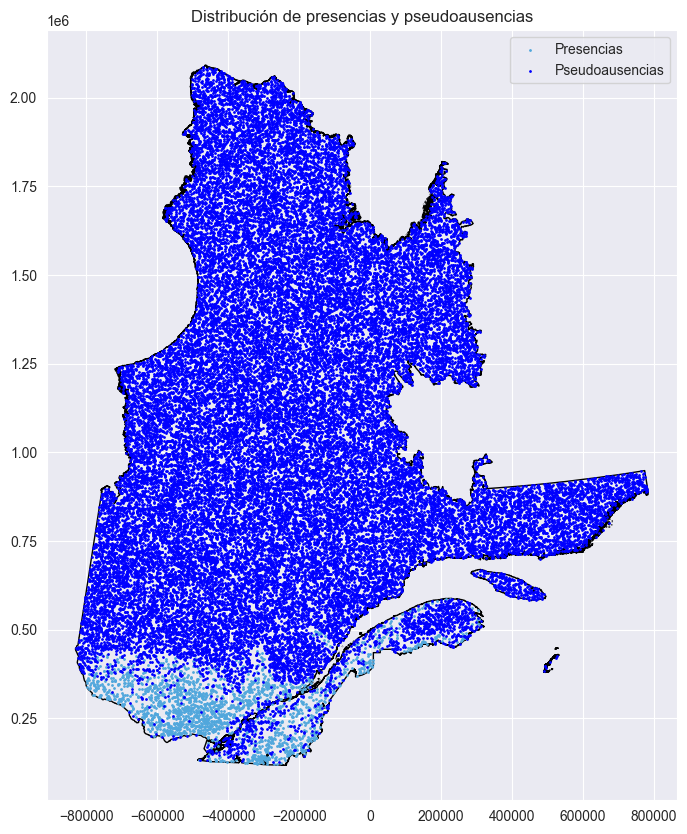

In [88]:
print("Graficando...")
ax = quebec_proj.plot(color='none', edgecolor='black', figsize=(10, 10))
presences_proj.sample(2000).plot(ax=ax, color='#51a7dc', markersize=1, label="Presencias")
pseudo_gdf.plot(ax=ax, color='blue', markersize=1, label="Pseudoausencias")
plt.legend()
plt.title("Distribución de presencias y pseudoausencias")
plt.show()

In [89]:
pseudo_gdf = gpd.GeoDataFrame(geometry=valid_points, crs="EPSG:32198")

# 11. Reproyectar de regreso a EPSG:4326 (latitud-longitud)
pseudo_gdf_latlon = pseudo_gdf.to_crs("EPSG:4326")

# 12. Extraer columnas de latitud y longitud
pseudo_gdf_latlon['longitude'] = pseudo_gdf_latlon.geometry.x
pseudo_gdf_latlon['latitude'] = pseudo_gdf_latlon.geometry.y

# 13. Crear un DataFrame plano si quieres
pseudo_df = pseudo_gdf_latlon[['latitude', 'longitude']].copy()

# 14. Guardar como CSV
pseudo_df.to_csv("data/pseudoausencias_latlon_sugarmaple.csv", index=False)


In [104]:
dsugm = dsug.drop(columns=['elev'])
pseusug = pseudo_df.copy()

In [107]:
print(dsugm.columns)

Index(['Unnamed: 0', 'essence', 'latitude', 'forest', 'longitude', 'ph',
       'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
       'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
       'bio27', 'bio30', 'bio31', 'bio34', 'cluster_k'],
      dtype='object')


In [109]:
ruta_rasters = "bioclim_data/recortados_alineados"
#dsugm
variables = [
'ph', 'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
'bio27', 'bio30', 'bio31', 'bio34'
]

In [110]:
geometry = [Point(lon, lat) for lon, lat in zip(pseusug['longitude'], pseusug['latitude'])]
pseudo_gdf = gpd.GeoDataFrame(pseusug.copy(), geometry=geometry, crs="EPSG:4326")

# 5. Crear columnas vacías para las variables
for var in variables:
    pseusug[var] = np.nan

In [111]:
for var in variables:
    print(f"Extrayendo valores de {var}.tif...")
    ruta_raster = os.path.join(ruta_rasters, f"{var}.tif")
    raster = rxr.open_rasterio(ruta_raster, masked=True).squeeze()  # quitar dimensión de banda

    # Asegurar CRS
    if raster.rio.crs is None:
        raster = raster.rio.write_crs("EPSG:4326")

    # Reproyectar puntos si es necesario
    if pseudo_gdf.crs != raster.rio.crs:
        pseudo_gdf = pseudo_gdf.to_crs(raster.rio.crs)

    # Extraer valores
    pseudo_gdf[var] = [float(raster.sel(x=pt.x, y=pt.y, method="nearest").values) for pt in pseudo_gdf.geometry]

Extrayendo valores de ph.tif...
Extrayendo valores de clay.tif...
Extrayendo valores de sand.tif...
Extrayendo valores de bio1.tif...
Extrayendo valores de bio2.tif...
Extrayendo valores de bio3.tif...
Extrayendo valores de bio8.tif...
Extrayendo valores de bio9.tif...
Extrayendo valores de bio10.tif...
Extrayendo valores de bio11.tif...
Extrayendo valores de bio12.tif...
Extrayendo valores de bio14.tif...
Extrayendo valores de bio15.tif...
Extrayendo valores de bio18.tif...
Extrayendo valores de bio20.tif...
Extrayendo valores de bio23.tif...
Extrayendo valores de bio24.tif...
Extrayendo valores de bio27.tif...
Extrayendo valores de bio30.tif...
Extrayendo valores de bio31.tif...
Extrayendo valores de bio34.tif...


In [113]:
# 8. Agregar columna de presencia
pseudo_gdf['presencia'] = 0  # 0 para pseudoausencias
pseudo_gdf

,latitude,longitude,geometry,ph,clay,sand,bio1,bio2,bio3,bio8,...,bio15,bio18,bio20,bio23,bio24,bio27,bio30,bio31,bio34,presencia
0,53.198261,-69.000124,POINT (-69.00012 53.19826),7.6000,43.0,85.0,-4.266730,9.688566,20.425425,7.164367,...,36.059238,305.475006,15.657077,108.081757,465.875000,37.670223,-13.661942,5.915907,464.337311,0
1,47.494139,-77.193602,POINT (-77.1936 47.49414),4.5000,85.0,85.0,1.828088,11.966080,25.011524,10.689865,...,23.902754,295.375000,18.713917,80.099297,602.149963,35.407711,-6.685908,10.303803,745.199768,0
2,60.919967,-71.221327,POINT (-71.22133 60.91997),7.6000,43.0,43.0,-8.738073,7.084904,17.161999,-2.469400,...,37.830318,94.324997,25.433130,72.724083,120.250000,33.083549,-14.847893,-1.132585,254.828201,0
3,48.972956,-71.865677,POINT (-71.86568 48.97296),5.3733,22.0,35.0,1.247217,11.078239,22.875557,11.224799,...,28.184200,308.000000,18.719456,83.731789,614.825012,36.702618,-6.036880,9.955601,685.042725,0
4,61.077897,-77.131025,POINT (-77.13102 61.0779),7.6000,43.0,43.0,-8.724920,6.880700,15.970385,-0.702315,...,36.948086,107.900002,25.398012,67.976746,138.199997,35.583534,-13.151275,-1.172730,262.154205,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,57.323282,-67.018396,POINT (-67.0184 57.32328),5.2000,34.0,73.0,-5.650702,8.978867,19.360666,-0.242343,...,28.412647,180.475006,20.511084,79.327698,272.450012,36.733246,-12.776980,0.775164,404.925537,0
39996,46.969680,-70.193143,POINT (-70.19314 46.96968),4.8000,13.0,31.0,2.668787,10.370920,24.467901,7.290042,...,14.240702,325.250000,15.264941,92.228348,685.099976,31.504333,-1.267048,7.503225,716.905762,0
39997,50.997269,-62.186214,POINT (-62.18621 50.99727),4.5000,85.0,85.0,-0.473120,9.023558,22.490021,-1.374671,...,19.407890,272.250000,12.973777,108.082314,552.549988,30.606159,-3.099315,0.727409,521.056030,0
39998,59.766925,-72.883309,POINT (-72.88331 59.76693),7.6000,43.0,43.0,-7.476233,7.333647,17.123541,-0.655160,...,32.256325,116.849998,24.440639,63.781532,150.375000,34.630135,-13.157319,0.351226,296.371582,0


In [114]:

dsugm['presencia'] = 1  # 1 para presencias

In [115]:
# Seleccionar columnas comunes
columnas_finales = variables + ['presencia', 'latitude', 'longitude']
dsugm = dsugm[columnas_finales]
pseudo_final = pseudo_gdf[columnas_finales]

dataset_final = pd.concat([dsugm, pseudo_final], ignore_index=True)

print("Dataset final creado con shape:", dataset_final.shape)

# 12. Guardar dataset listo para modelar
dataset_final.to_csv("data/dataset_distribucion_xgboost_sugar.csv", index=False)


Dataset final creado con shape: (605308, 24)


In [116]:
dataset_final


,ph,clay,sand,bio1,bio2,bio3,bio8,bio9,bio10,bio11,...,bio20,bio23,bio24,bio27,bio30,bio31,bio34,presencia,latitude,longitude
0,4.2000,11.0,56.0,2.377832,10.493436,23.953115,6.911122,-3.073537,15.910181,-12.535620,...,16.870762,86.148476,633.375000,32.459473,-1.594780,7.549124,708.932800,1,47.996187,-68.500146
1,4.2000,11.0,56.0,2.377832,10.493436,23.953115,6.911122,-3.073537,15.910181,-12.535620,...,16.870762,86.148476,633.375000,32.459473,-1.594780,7.549124,708.932800,1,47.849696,-68.513409
2,4.3200,4.0,85.0,1.877924,9.285575,22.283415,6.653110,-2.865963,14.958370,-12.709820,...,16.294031,90.193054,615.300000,31.653698,-2.362497,5.388228,645.531100,1,48.006817,-69.845383
3,3.5167,24.0,45.0,2.599420,9.996067,23.503838,7.131128,0.016549,15.960852,-11.905567,...,17.312328,82.792880,613.000000,31.961720,-1.030399,6.622469,701.659550,1,47.464966,-69.830670
4,3.8233,16.0,43.0,2.377832,10.493436,23.953115,6.911122,-3.073537,15.910181,-12.535620,...,16.870762,86.148476,633.375000,32.459473,-1.594780,7.549124,708.932800,1,47.692467,-68.633707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605303,5.2000,34.0,73.0,-5.650702,8.978867,19.360666,-0.242343,-11.997272,9.634137,-22.459259,...,20.511084,79.327698,272.450012,36.733246,-12.776980,0.775164,404.925537,0,57.323282,-67.018396
605304,4.8000,13.0,31.0,2.668787,10.370920,24.467901,7.290042,-0.722303,15.669240,-11.796894,...,15.264941,92.228348,685.099976,31.504333,-1.267048,7.503225,716.905762,0,46.969680,-70.193143
605305,4.5000,85.0,85.0,-0.473120,9.023558,22.490021,-1.374671,-4.198558,12.063941,-14.478942,...,12.973777,108.082314,552.549988,30.606159,-3.099315,0.727409,521.056030,0,50.997269,-62.186214
605306,7.6000,43.0,43.0,-7.476233,7.333647,17.123541,-0.655160,-14.596632,6.814635,-23.605196,...,24.440639,63.781532,150.375000,34.630135,-13.157319,0.351226,296.371582,0,59.766925,-72.883309


In [118]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
print("Eliminando duplicados lat/lon...")
dataset_final = dataset_final.drop_duplicates(subset=['latitude', 'longitude'])

Eliminando duplicados lat/lon...


In [121]:
print("Shape final después de limpieza:", dataset_final.shape)

Shape final después de limpieza: (605308, 24)


In [122]:
X = dataset_final[['ph', 'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
'bio27', 'bio30', 'bio31', 'bio34']]

In [123]:
y = dataset_final['presencia']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [125]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

ModuleNotFoundError: No module named 'skopt'